# Custom Datasets

### [Resource](https://www.learnpytorch.io/04_pytorch_custom_datasets/)

We've used some datasets with PyTorch before. But how do you get your own data into PyTorch?

One of the ways to do so is via: **custom datasets**.

## Domain Libraries

Depending on what you're working on vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

In that case, we can always subclass [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and customize it to our liking.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-domain-libraries.png">


| Problem Space   | Pre-built Datasets and Functions|             
|-----------------|-----------------------------|
| Vision                 | [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html)|
| Audio                  | [`torchaudio.datasets`](https://pytorch.org/audio/stable/datasets.html)|
| Text                   | [`torchtext.datasets`](https://pytorch.org/text/stable/datasets.html)|
| Recommendation System  | [`torchrec.datasets`](https://pytorch.org/torchrec/torchrec.datasets.html)|



## Content to Cover in Computer Vision

We're going to be using our own dataset of pizza, steak and sushi images.

The goal will be to load these images and then build a model to train and predict on them.

<img src = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-food-vision-layout.png">

| Topic                                     | Contents                                                                                     |
|-------------------------------------------|----------------------------------------------------------------------------------------------|
| 0. Importing PyTorch and setting up device-agnostic code   | Let's get PyTorch loaded and set up code to be device-agnostic.                               |
| 1. Get data                               | Use a **custom dataset** of pizza, steak, and sushi images.                                        |
| 2. Become one with the data(data preparation)         | Understand the dataset at the beginning of a machine learning problem.                         |
| 3. Transforming data                      | Prepare data for machine learning models.                                                     |
| 4. Loading data with ImageFolder (option 1)| Use PyTorch's ImageFolder for standard image classification format.                            |
| 5. Loading image data with a custom Dataset | Build a custom subclass of [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for non-standard data.                    |
| 6.  Other forms of transforms (data augmentation) | Explore torchvision's in-built data augmentation functions.                                   |
| 7. Model 0: TinyVGG without data augmentation | Build and train a model without data augmentation.                                            |
| 8. Exploring loss curves                   | Analyze loss curves to evaluate model training and performance.                                |
| 9. Model 1: TinyVGG with data augmentation | Build and train a model with data augmentation.                                               |
| 10. Compare model results                 | Compare loss curves and discuss performance improvement options.                              |
| 11. Making a prediction on a custom image | Use the trained model to predict on an image outside the dataset.                               |


## 0. Importing PyTorch and setting up device-agnostic code

In [ ]:
import torch
from torch import nn

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

2.1.0+cu121
cpu


## 1. Get Data
We're commencing with a subset of the [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), a renowned computer vision benchmark comprising 101,000 images of 101 distinct foods. To simplify, we're narrowing our focus to three delectable classes: pizza, steak, and sushi. Instead of 1,000 images per class, we're starting with a random 30% (begin modestly, scale up as needed).

*Refer to the [Extras/Pytorch_Custom_Food_Datasets.ipynb](https://github.com/LuluW8071/Data-Science/tree/main/Pytorch/04_PyTorch_Custom_Datasets/Extras/Pytorch_Custom_Food_Datasets.ipynb) notebook for creating a subset of the Food101 dataset*.

[*Download the prepared custom dataset here separately*](https://github.com/LuluW8071/Data-Science/tree/main/Pytorch/04_PyTorch_Custom_Datasets/Extras)

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/LuluW8071/Data-Science/raw/main/Pytorch/04_PyTorch_Custom_Datasets/Extras/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

data directory exists.
Unzipping pizza, steak, sushi data...


## 2. Become one with the data(data preparation)
<img src = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-abraham-lossfunction.png">

The storage format below, the images numbers are arbitrary.
```
data/pizza_steak_sushi/ <- overall dataset folder
    train/ <- training images
        pizza/ <- class name as folder name
            image01.jpeg
            image02.jpeg
            ...
        steak/
            image24.jpeg
            image25.jpeg
            ...
        sushi/
            image37.jpeg
            ...
    test/ <- testing images
        pizza/
            image101.jpeg
            image102.jpeg
            ...
        steak/
            image154.jpeg
            image155.jpeg
            ...
        sushi/
            image167.jpeg
            ...
```

The goal will be to take this **data storage structure and turn it into a dataset usable with PyTorch**.

In [ ]:
import os

def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 1 directories and 1 images in 'data'.
There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 70 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 71 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 84 images in 'data/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 221 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 228 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 226 images in 'data/pizza_steak_sushi/train/steak'.


In [ ]:
# Setup train and test paths
train_dir = image_path / 'pizza_steak_sushi/train'
test_dir = image_path / 'pizza_steak_sushi/test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing Image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's [PIL](https://pypi.org/project/pillow/)
5. We'll then show the image and print metadata

Random image path: data/pizza_steak_sushi/train/sushi/1571146.jpg
Image Class: sushi
Image Height: 384
Image Width: 512


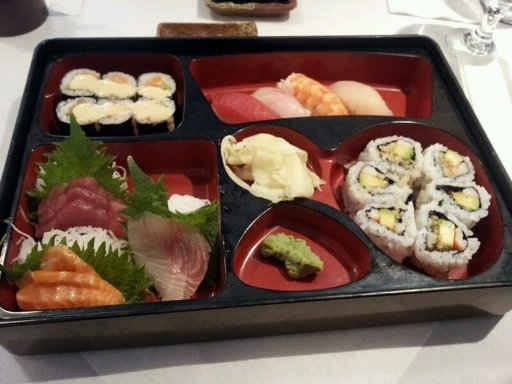

In [ ]:
import random
from PIL import Image

# random.seed(42)

# 1. Get all of the image paths
image_path = data_path / "pizza_steak_sushi"
image_path_list = list(image_path.glob("*/*/*.jpg"))  # *(data)/*(pizza_steak_sushi)/*(testORtrain)/.jpg

# 2. Pick a random image path using Python's random.choice()
random_image_path = random.choice(image_path_list)
# print(random_image_path)

# 3. Get the image class from path name
# the image class is the name of the directory where
image_class = random_image_path.parent.stem
# print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Random image path: {random_image_path}')
print(f'Image Class: {image_class}')
print(f'Image Height: {img.height}')
print(f'Image Width: {img.width}')
img

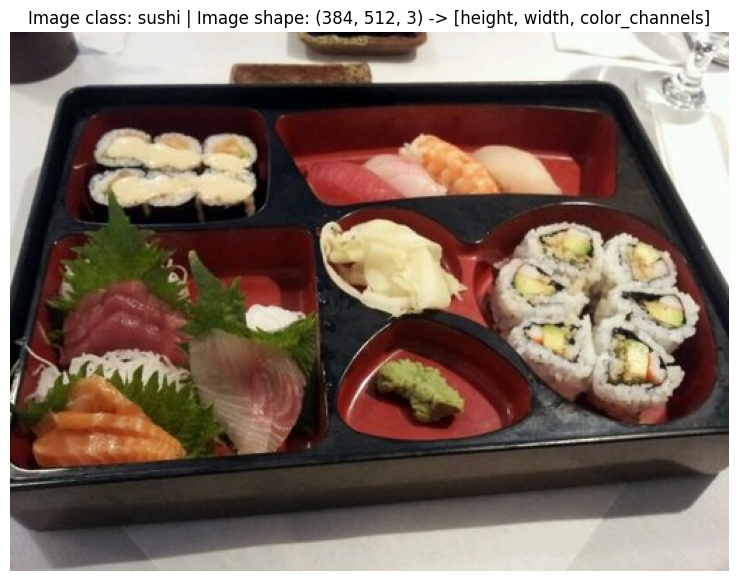

In [ ]:
# Visualizing using matplotliib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
fig = plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)
plt.show()

In [ ]:
img_as_array

array([[[ 36,  26,  35],
        [ 34,  24,  33],
        [ 33,  23,  32],
        ...,
        [145, 142, 133],
        [164, 160, 151],
        [176, 172, 163]],

       [[ 37,  27,  36],
        [ 36,  26,  35],
        [ 34,  24,  33],
        ...,
        [150, 147, 138],
        [149, 145, 136],
        [147, 143, 134]],

       [[ 39,  29,  38],
        [ 38,  28,  37],
        [ 37,  27,  36],
        ...,
        [185, 182, 173],
        [183, 180, 171],
        [180, 177, 168]],

       ...,

       [[158, 148, 156],
        [160, 150, 158],
        [164, 154, 162],
        ...,
        [204, 197, 191],
        [201, 194, 188],
        [198, 191, 185]],

       [[166, 156, 164],
        [167, 157, 165],
        [167, 157, 165],
        ...,
        [204, 197, 191],
        [199, 192, 186],
        [194, 187, 181]],

       [[166, 156, 164],
        [165, 155, 163],
        [164, 154, 162],
        ...,
        [203, 196, 190],
        [198, 191, 185],
        [192, 185, 179]]

## 3. Transforming data
Before we can use our image data with PyTorch
1. Turn your target data into tensors (in our case, numerical representation of our images.)
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader` for short.

### 3.1 Transforming data with [`torchvision.transforms`](https://pytorch.org/vision/0.9/transforms.html)

Transforms help you get your images ready toi be used with a model/perform data augmentation.

In [ ]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

print(torchvision.__version__)

0.16.0+cu121


In [ ]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 256x256
    transforms.Resize(size = (256, 256)),
    # Flip the images randomly on the horizontally
    transforms.RandomHorizontalFlip(p = 0.5),
    # Turn image into Tensor
    transforms.ToTensor()
])

In [ ]:
transformed_data = data_transform(img)

transformed_data, transformed_data.shape, transformed_data.dtype

(tensor([[[0.6235, 0.5765, 0.6118,  ..., 0.1294, 0.1294, 0.1373],
          [0.6902, 0.7020, 0.7373,  ..., 0.1412, 0.1412, 0.1490],
          [0.8980, 0.8627, 0.8510,  ..., 0.1490, 0.1569, 0.1608],
          ...,
          [0.7922, 0.8078, 0.8196,  ..., 0.6510, 0.6431, 0.6235],
          [0.7843, 0.8039, 0.8039,  ..., 0.6510, 0.6471, 0.6353],
          [0.7725, 0.7961, 0.7882,  ..., 0.6431, 0.6471, 0.6510]],
 
         [[0.6118, 0.5647, 0.6000,  ..., 0.0902, 0.0902, 0.0980],
          [0.6745, 0.6902, 0.7255,  ..., 0.1020, 0.1020, 0.1098],
          [0.8863, 0.8510, 0.8431,  ..., 0.1098, 0.1176, 0.1216],
          ...,
          [0.7647, 0.7804, 0.7922,  ..., 0.6118, 0.6039, 0.5843],
          [0.7569, 0.7765, 0.7765,  ..., 0.6118, 0.6078, 0.5961],
          [0.7451, 0.7686, 0.7608,  ..., 0.6039, 0.6078, 0.6118]],
 
         [[0.5765, 0.5294, 0.5647,  ..., 0.1255, 0.1255, 0.1333],
          [0.6392, 0.6549, 0.6902,  ..., 0.1333, 0.1373, 0.1451],
          [0.8510, 0.8157, 0.8078,  ...,

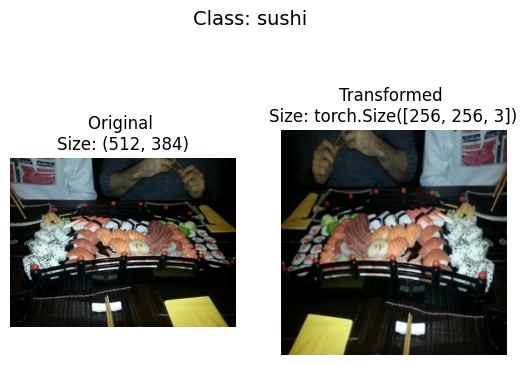

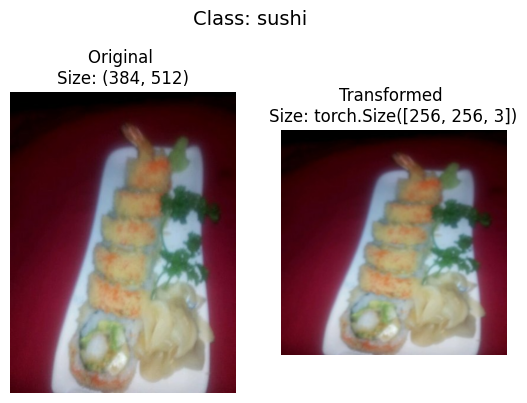

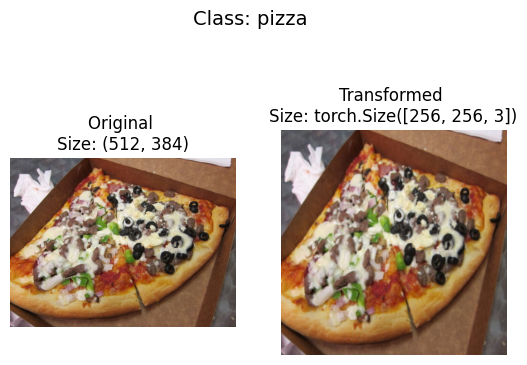

In [ ]:
def plot_transformed_images(image_paths, transform, n, seed):
  """Selects random images from a path of images and loads/transforms them then plots the original vs the transformed version."""
  # random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
      with Image.open(image_path) as f:
          fig, ax = plt.subplots(1, 2)
          ax[0].imshow(f)
          ax[0].set_title(f"Original \nSize: {f.size}")
          ax[0].axis("off")

          # Transform and plot image
          # Note: permute() will change shape of image to suit matplotlib
          # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
          transformed_image = transform(f).permute(1, 2, 0)
          ax[1].imshow(transformed_image)
          ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
          ax[1].axis("off")

          fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=14)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n = 3,
                        seed = 42)

## 4. Loading data with [`ImageFolder`](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) (option 1)
We can load image classification data using [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html)

In [ ]:
from torchvision import datasets

train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform, # Transforms input data into tensors
                                  target_transform = None)  # Transform labels into none

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 675
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# Get class names as lists
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
train_data.samples[:500:50]

[('data/pizza_steak_sushi/train/pizza/1008104.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1947572.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/271592.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/350358.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/739735.jpg', 0),
 ('data/pizza_steak_sushi/train/steak/1624747.jpg', 1),
 ('data/pizza_steak_sushi/train/steak/2287136.jpg', 1),
 ('data/pizza_steak_sushi/train/steak/2938151.jpg', 1),
 ('data/pizza_steak_sushi/train/steak/38442.jpg', 1),
 ('data/pizza_steak_sushi/train/sushi/1033302.jpg', 2)]

In [ ]:
# Index on the train_data Dataset to get a single iamge and label
img, label = train_data[0][0], train_data[0][1]

img, img.dtype, label, type(label), class_names[label]

(tensor([[[0.2431, 0.2588, 0.2549,  ..., 0.2039, 0.1647, 0.1412],
          [0.2000, 0.2118, 0.2196,  ..., 0.2157, 0.1686, 0.1529],
          [0.1294, 0.1412, 0.1569,  ..., 0.2471, 0.1961, 0.1882],
          ...,
          [0.4235, 0.4353, 0.4471,  ..., 0.4431, 0.4392, 0.4431],
          [0.4118, 0.4275, 0.4392,  ..., 0.4431, 0.4353, 0.4314],
          [0.4000, 0.4157, 0.4275,  ..., 0.4392, 0.4353, 0.4314]],
 
         [[0.2588, 0.2745, 0.2706,  ..., 0.2157, 0.1765, 0.1529],
          [0.2157, 0.2275, 0.2353,  ..., 0.2275, 0.1804, 0.1647],
          [0.1412, 0.1529, 0.1686,  ..., 0.2588, 0.2078, 0.2000],
          ...,
          [0.4784, 0.4941, 0.5059,  ..., 0.4667, 0.4627, 0.4627],
          [0.4667, 0.4824, 0.4980,  ..., 0.4627, 0.4549, 0.4510],
          [0.4549, 0.4706, 0.4863,  ..., 0.4588, 0.4549, 0.4510]],
 
         [[0.2000, 0.2157, 0.2118,  ..., 0.1333, 0.1020, 0.0784],
          [0.1608, 0.1725, 0.1765,  ..., 0.1451, 0.1059, 0.0902],
          [0.0941, 0.1059, 0.1216,  ...,

In [ ]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)
img.shape, img_permute.shape

(torch.Size([3, 256, 256]), torch.Size([256, 256, 3]))

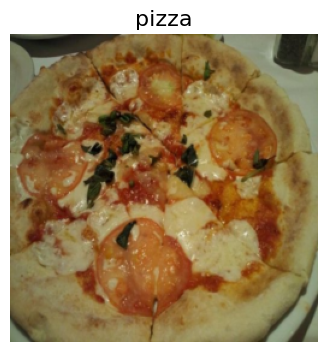

In [ ]:
# Plot the image
plt.figure(figsize = (4, 4))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize = 16);

### 4.1 Turn loaded images into `Dataloaders`
A `Dataloader` is going to help us tuirn out `Dataset` into iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time.

In [87]:
# Train and test dataloaders
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = 1,    # num workers are cpu cores {in colab:2 | in localMachine:maybeMore}
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = 1,
                             shuffle = False)

len(train_dataloader), len(test_dataloader)

(22, 8)

In [ ]:
img, label = next(iter(train_dataloader))

img.shape, label.shape     # {img.shape} -> [batch_size, color_channels, height, width]

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

## 5. Loading image data with a custom `Dataset`

- Want to be able to load images from file
- Want to be able to get class names from the Dataset
- Want to be able to get classe as dictionary from the Dataset


|Pros of creating a custom `Dataset`	|Cons of creating a custom `Dataset`|
|-----------------------------------|---------------------------------|
|Can create a `Dataset` out of almost anything.	|Even though you could create a `Dataset` out of almost anything, it doesn't mean it will work.
|Not limited to PyTorch pre-built `Dataset` functions.| Using a custom `Dataset` often results in writing more code, which could be prone to errors or performance issues.|

All custom datasets in PyTorch, often subclass - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [88]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [89]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})